## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors: Paul Doucet, Jerry Khidaroo

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"I need to take my car into Intelligent Auto Solutions What day would you like to take your car in? As soon as possible What is the reason for your appointment? I'm leaking oil all over the driveway. What is the make and model of your car? It's a 2015 BMW 750i with 150,000 miles Thank you. May I have your name and contact number? Jane Smith. 593-222-8777 There is an opening Friday at 9:00 am. That won't work I need something sooner. There is an opening Thursday at 12:00 pm. That will work but is there any times sooner than 12:00 pm? There is an earlier time at 8:00 am. Yes that will be fine. I have secured that time for you. Thank you. Is there anything else I can help with? No Thank you. I have confirmed your appointment at Intelligent Auto Solutions for Thursday at 8:00 am. Thank you Thank you and have a nice day",auto-repair-appt-1,0
126,Hi can you book me an appointment to get my car fixed? Yes where do you want me to book the appointment at? Intellegent Auto Solutions Ok. What is the make and model of your car? I have a 2019 Chevy Impala. What's wrong with your car? My muffler keeps making a loud noise. Can you give me your full name and phone number so the mechanic can reach you? Sarah Heartly 305-768-5566 What day would you like to get it fixed? Thursday They are completely booked for Thursday. How about Friday? What time Friday? 10 o'clock in the morning. Unfortunately 10 o'clock is booked. There is a later time for 12 o'clock p.m. . I'll take that time. Ok I will set the appointment for you to get the muffler checked out at 12 o'clock p.m. on Friday for your 2019 Chevy Impala. Thank you. There will be an inspection fee of $25. Ok Your appointment has been booked. Thank you so much. You are welcome.,auto-repair-appt-1,0
555,"Hey there, can you do me a favor and buy a pair of tickets to a movie tonight? Of course! What movie are you looking to see? I've been dying to see ""Isn't it Romantic""! Great. And you're in Seattle tonight, right? Yep, Seattle. Okay, great. It looks like the nearest theater to you will be the Pacific Place. Sound okay? Okay, great. What's the next showtime? It looks like the next time is at 7:05pm. Do you think you can make it there in time? Yep! We're close, so 7:05pm will do just fine. And you said two tickets? Yes, as close to the center as possible, please. Got it. Tickets are $13.85, so together that'll be $27.70. Jeez movies have gotten expensive. But alright, you can charge it to my account. Okie dokie! Done. Great, thanks! How do I access the tickets? I'll text you the details, there will be a link to open your tickets in the app. Okay, perfect. Thank you! This will save us so much time. Great. Is there anything else I can do? No, thank you, that will be all. Okay, enjoy the movie! Thank you! Have a great night.",movie-tickets-1,1
1260,"I'm looking for a good Italian restaurant to make reservations for. I am happy to help. Do you already have a specific restaurant in mind? No, I was hoping you might have recommendations for somewhere in West Portland. Sure, there are several nice Italian restuarants in West Portland. Were you looking for a more casual or upscale experience? Definately upscale. And I need the reservation for this Sunday at 5PM. Ava Genes is a very nice Italian restaurant in West Portland. Shall I make the reservatin for the table for you? Yes, and I'll be needing a table for four, please. I'm sorry, there are no reservations available at that time. Would you like to try for 6pm, instead? Sure, try for that time. I'm sorry, there are tables available at 6pm, but only tables for two are available at that time. Would you like me to try another time? No, I'd rather try at another restaurant for the original time of Sunday at 5PM, please. There must be another good Italian place available? Mucca Osteria is very nice, would you like to try this restaurant? Sure! It sounds good! It's all set! Mucca Osteria this Sunday at 5pm table for

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"I need to take my car into Intelligent Auto Solutions What day would you like to take your car in? As soon as possible What is the reason for your appointment? I'm leaking oil all over the driveway. What is the make and model of your car? It's a 2015 BMW 750i with 150,000 miles Thank you. May I have your name and contact number? Jane Smith. 593-222-8777 There is an opening Friday at 9:00 am. That won't work I need something sooner. There is an opening Thursday at 12:00 pm. That will work but is there any times sooner than 12:00 pm? There is an earlier time at 8:00 am. Yes that will be fine. I have secured that time for you. Thank you. Is there anything else I can help with? No Thank you. I have confirmed your appointment at Intelligent Auto Solutions for Thursday at 8:00 am. Thank you Thank you and have a nice day",auto-repair-appt-1,0,need take car intelligent auto solutions day would like take car soon possible reason appointment im leaking oil driveway make model car bmw miles thank may name contact number jane smith opening friday wont work need something sooner opening thursday pm work times sooner pm earlier time yes fine secured time thank anything else help thank confirmed appointment intelligent auto solutions thursday thank thank nice day
126,Hi can you book me an appointment to get my car fixed? Yes where do you want me to book the appointment at? Intellegent Auto Solutions Ok. What is the make and model of your car? I have a 2019 Chevy Impala. What's wrong with your car? My muffler keeps making a loud noise. Can you give me your full name and phone number so the mechanic can reach you? Sarah Heartly 305-768-5566 What day would you like to get it fixed? Thursday They are completely booked for Thursday. How about Friday? What time Friday? 10 o'clock in the morning. Unfortunately 10 o'clock is booked. There is a later time for 12 o'clock p.m. . I'll take that time. Ok I will set the appointment for you to get the muffler checked out at 12 o'clock p.m. on Friday for your 2019 Chevy Impala. Thank you. There will be an inspection fee of $25. Ok Your appointment has been booked. Thank you so much. You are welcome.,auto-repair-appt-1,0,hi book appointment get car fixed yes want book appointment intellegent auto solutions ok make model car chevy impala whats wrong car muffler keeps making loud noise give full name phone number mechanic reach sarah heartly day would like get fixed thursday completely booked thursday friday time friday oclock morning unfortunately oclock booked later time oclock pm ill take time ok set appointment get muffler checked oclock pm friday chevy impala thank inspection fee ok appointment booked thank much welcome
555,"Hey there, can you do me a favor and buy a pair of tickets to a movie tonight? Of course! What movie are you looking to see? I've been dying to see ""Isn't it Romantic""! Great. And you're in Seattle tonight, right? Yep, Seattle. Okay, great. It looks like the nearest theater to you will be the Pacific Place. Sound okay? Okay, great. What's the next showtime? It looks like the next time is at 7:05pm. Do you think you can make it there in time? Yep! We're close, so 7:05pm will do just fine. And you said two tickets? Yes, as close to the center as possible, please. Got it. Tickets are $13.85, so together that'll be $27.70. Jeez movies have gotten expensive. But alright, you can charge it to my account. Okie dokie! Done. Great, thanks! How do I access the tickets? I'll text you the details, there will be a link to open your tickets in the app. Okay, perfect. Thank you! This will save us so much time. Great. Is there anything else I can do? No, thank you, that will be all. Okay, enjoy the movie! Thank you! Have a great night.",movie-tickets-1,1,hey favor buy pair tickets movie tonight course movie looking see ive dying see isnt romantic great youre seattle tonight right yep seattle okay great looks like nearest theater pacific

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi book appointment get car fixed yes want book appointment intellegent auto solutions ok make model car chevy impala whats wrong car muffler keeps making loud noise give full name phone number mechanic reach sarah heartly day would like get fixed thursday completely booked thursday friday time friday oclock morning unfortunately oclock booked later time oclock pm ill take time ok set appointment get muffler checked oclock pm friday chevy impala thank inspection fee ok appointment booked thank much welcome',
 'hey favor buy pair tickets movie tonight course movie looking see ive dying see isnt romantic great youre seattle tonight right yep seattle okay great looks like nearest theater pacific place sound okay okay great whats next showtime looks like next time pm think make time yep close pm fine said two tickets yes close center possible please got tickets together thatll jeez movies gotten expensive alright charge account okie dokie done great thanks access tickets ill text details

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5748
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('want', 6), ('pm', 7), ('order', 8), ('thank', 9), ('time', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['need', 'take', 'intelligent', 'auto'] -> Target (Y): car
Context (X): ['take', 'car', 'auto', 'solutions'] -> Target (Y): intelligent
Context (X): ['car', 'intelligent', 'solutions', 'day'] -> Target (Y): auto
Context (X): ['intelligent', 'auto', 'day', 'would'] -> Target (Y): solutions
Context (X): ['auto', 'solutions', 'would', 'like'] -> Target (Y): day
Context (X): ['solutions', 'day', 'like', 'take'] -> Target (Y): would
Context (X): ['day', 'would', 'take', 'car'] -> Target (Y): like
Context (X): ['would', 'like', 'car', 'soon'] -> Target (Y): take
Context (X): ['like', 'take', 'soon', 'possible'] -> Target (Y): car
Context (X): ['take', 'car', 'possible', 'reason'] -> Target (Y): soon
Context (X): ['car', 'soon', 'reason', 'appointment'] -> Target (Y): possible


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 6, 5, ..., 0, 0, 1]], dtype=int64)

In [19]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,want,pm,order,thank,time,tickets,please,need,one,...,serifina,terrazzo,serafina,nonitalian,enhancements,piped,puget,operating,happened,surgery,grandma,regards,everythings,golbert,anyhow
0,0,1,1,0,0,1,0,2,0,5,2,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,3,1,1,2,0,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,5,0,1,0,2,0,3,3,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,5,5,0,0,2,0,6,0,0,7,0,4,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,0,1,4,0,2,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,4,2,10,0,0,0,0,4,0,0,0,0,1,5,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,2,1,0,0,5,2,4,0,0,1,0,0,1,0,...,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
997,0,0,0,1,0,2,4,0,1,2,0,0,2,5,0,...,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0
998,0,1,0,2,0,1,1,2,0,2,2,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [20]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5748)
(250, 5748)
(250,)


#### Define Model Builder Function

In [21]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Features Baseline Benchmarking with LinearSVC Classifier

In [22]:
from sklearn.svm import LinearSVC

model_svc_bow = LinearSVC()
cm_svc_bow, pred_svc_bow, f1_svc_bow, report_svc_bow, accuracy_svc_bow = Build_Model(model_svc_bow, X_train_bow, y_train, X_test_bow, y_test)

In [23]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW LinearSVC All Features", f1_svc_bow, accuracy_svc_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68


In [24]:
from sklearn.metrics import confusion_matrix

cm_svc_bow

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1, 15,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 14,  8,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  8,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  6, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 11, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  7, 14,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  1, 10,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0, 11,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  4, 12]],
      dtype=int64)

In [25]:
print(accuracy_svc_bow)

0.684


In [26]:
from sklearn import metrics

print(report_svc_bow)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.75      0.79      0.77        19
 coffee-ordering-2       0.81      0.81      0.81        16
      movie-finder       0.90      0.82      0.86        11
   movie-tickets-1       0.56      0.70      0.62        20
   movie-tickets-2       0.47      0.36      0.41        22
   movie-tickets-3       0.74      0.71      0.72        24
  pizza-ordering-1       0.43      0.21      0.29        14
  pizza-ordering-2       0.61      0.83      0.70        23
restaurant-table-1       0.75      0.41      0.53        22
restaurant-table-2       0.52      0.82      0.64        17
restaurant-table-3       0.67      0.62      0.65        16
       uber-lyft-1       0.85      0.73      0.79        15
       uber-lyft-2       0.71      0.92      0.80        13

          accuracy                           0.68       250
         macro avg       0.70      0.69      0.68       25

#### Bag of Words Feature Benchmarking with Naive Bayes Classifier

In [27]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [28]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72


In [29]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11, 16,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 17,  8,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  3, 10,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  4, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 21,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11, 15,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 12]],
      dtype=int64)

In [30]:
from sklearn import metrics

print(report_nb_bow)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.42      0.59        19
 coffee-ordering-2       0.57      1.00      0.73        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.63      0.85      0.72        20
   movie-tickets-2       0.56      0.45      0.50        22
   movie-tickets-3       0.83      0.79      0.81        24
  pizza-ordering-1       0.75      0.43      0.55        14
  pizza-ordering-2       0.72      0.91      0.81        23
restaurant-table-1       0.89      0.36      0.52        22
restaurant-table-2       0.45      0.88      0.60        17
restaurant-table-3       0.75      0.56      0.64        16
       uber-lyft-1       0.91      0.67      0.77        15
       uber-lyft-2       0.75      0.92      0.83        13

          accuracy                           0.72       250
         macro avg       0.77      0.73      0.72       25

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [99]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [34]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

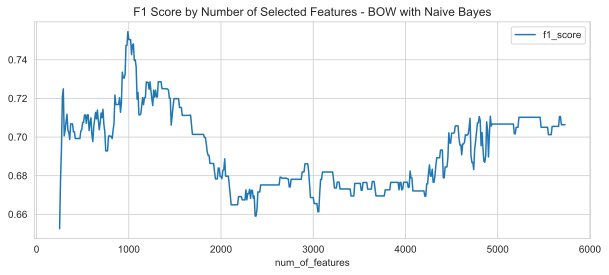

In [35]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [36]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
74,990,0.75,0.76
75,1000,0.75,0.75
76,1010,0.75,0.75
77,1020,0.75,0.75
80,1050,0.75,0.75


#### Get a more fine-grained look at the optimal number of features region

In [37]:
rows = []
for i in range(950, 1050, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

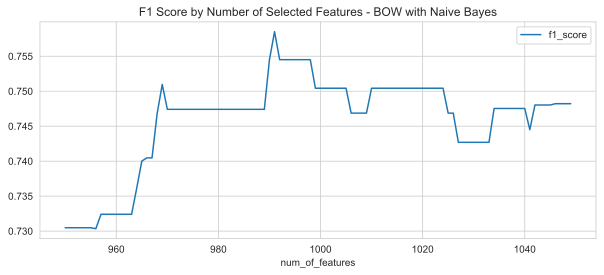

In [38]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [39]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
41,991,0.76,0.76
45,995,0.75,0.76
48,998,0.75,0.76
47,997,0.75,0.76
46,996,0.75,0.76


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [40]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

991

In [41]:
model_nb_bow_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [42]:
print(cm_optimal)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  8 15  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 17  7  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  3 14  4  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  7 20  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  5 14  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  3  1 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  9  1]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  5 12]]


In [43]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.92      0.58      0.71        19
 coffee-ordering-2       0.62      0.94      0.75        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.65      0.85      0.74        20
   movie-tickets-2       0.67      0.64      0.65        22
   movie-tickets-3       0.95      0.83      0.89        24
  pizza-ordering-1       0.70      0.50      0.58        14
  pizza-ordering-2       0.74      0.87      0.80        23
restaurant-table-1       0.87      0.59      0.70        22
restaurant-table-2       0.56      0.82      0.67        17
restaurant-table-3       0.71      0.62      0.67        16
       uber-lyft-1       0.90      0.60      0.72        15
       uber-lyft-2       0.71      0.92      0.80        13

          accuracy                           0.76       250
         macro avg       0.79      0.76      0.76       25

In [44]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76


## TF-IDF Feature Extraction

In [45]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 4941)
(250, 4941)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [46]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [47]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 4941)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [48]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 16,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 19, 13,  2,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  4,  1,  9,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  4,  0,  0, 17,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 12, 23,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 19, 17, 12,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  4,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 12]],
      dtype=int64)

In [49]:
from sklearn import metrics

print(report_nb_tfidf)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.44      1.00      0.62        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.50      0.95      0.66        20
   movie-tickets-2       0.47      0.41      0.44        22
   movie-tickets-3       0.81      0.71      0.76        24
  pizza-ordering-1       1.00      0.14      0.25        14
  pizza-ordering-2       0.66      1.00      0.79        23
restaurant-table-1       1.00      0.05      0.09        22
restaurant-table-2       0.35      1.00      0.52        17
restaurant-table-3       0.80      0.25      0.38        16
       uber-lyft-1       0.91      0.67      0.77        15
       uber-lyft-2       0.75      0.92      0.83        13

          accuracy                           0.59       250
         macro avg       0.62      0.58      0.51       25

In [50]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59


In [90]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes Multinomial

In [53]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

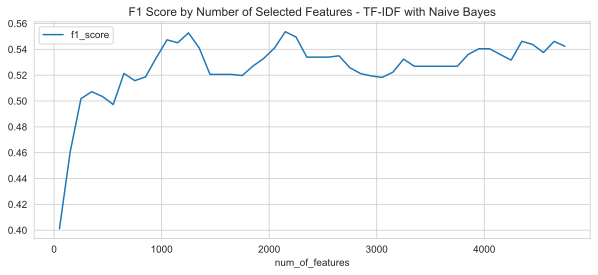

In [54]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [55]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
21,2150,0.55,0.61
12,1250,0.55,0.60
22,2250,0.55,0.61
10,1050,0.55,0.60
43,4350,0.55,0.61


#### Take closer look at region around 1150 features

In [56]:
rows = []
for i in range(1150, 1250, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

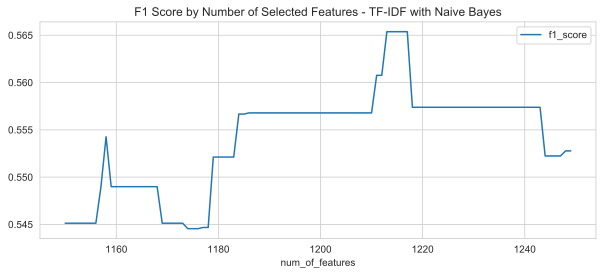

In [57]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [58]:
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
66,1216,0.57,0.61
67,1217,0.57,0.61
63,1213,0.57,0.61
64,1214,0.57,0.61
65,1215,0.57,0.61


#### Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [59]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, 1216, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: 1115", f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61


## TF-IDF Benchmarking with LinearSVC

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

model_svc_tfidf = LinearSVC()
cm_svc_tfidf, pred_svc_tfidf, f1_svc_tfidf, report_svc_tfidf, accuracy_svc_tfidf = Build_Model(model_svc_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Show Confusion Matrix Heat Map for TF-IDF LinearSVC baseline

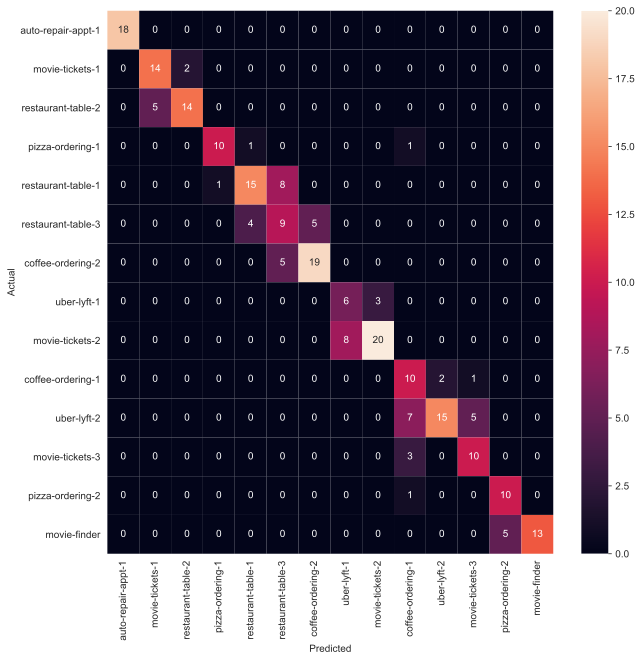

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_svc_tfidf, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Confusion Matrix for Linear SVC on TF-IDF features

In [62]:
cm_svc_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 15,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  9,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  5, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  3,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8, 20,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  2,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 15,  5,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0, 10,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, 10,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5, 13]],
      dtype=int64)

#### Metrics For Each Class

In [63]:
from sklearn import metrics
print(report_svc_tfidf)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.88      0.74      0.80        19
 coffee-ordering-2       0.74      0.88      0.80        16
      movie-finder       0.83      0.91      0.87        11
   movie-tickets-1       0.62      0.75      0.68        20
   movie-tickets-2       0.50      0.41      0.45        22
   movie-tickets-3       0.79      0.79      0.79        24
  pizza-ordering-1       0.67      0.43      0.52        14
  pizza-ordering-2       0.71      0.87      0.78        23
restaurant-table-1       0.77      0.45      0.57        22
restaurant-table-2       0.56      0.88      0.68        17
restaurant-table-3       0.77      0.62      0.69        16
       uber-lyft-1       0.91      0.67      0.77        15
       uber-lyft-2       0.72      1.00      0.84        13

          accuracy                           0.73       250
         macro avg       0.75      0.74      0.73       25

In [64]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF LinearSVC All Features", f1_svc_tfidf, accuracy_svc_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61
5,TF-IDF LinearSVC All Features,0.72,0.73


## Word2Vec Feature Extraction

In [65]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['warranty', 'np', 'takes', 'case', 'working'],
 'pizza': ['pepperoni', 'johns', 'large', 'crust', 'papa'],
 'terminator': ['judgment', 'abyss', 'sigourney', 'alien', 'weaver'],
 'star': ['wars', 'jedi', 'scifi', 'vi', 'mystery'],
 'audi': ['experiencing', 'acceleration', 'hesitation', 'explain', 'fastest'],
 'east': ['mall', 'america', 'broadway', 'rd', 'abigail'],
 'korean': ['bbq', 'lauderhill', 'pig', 'bbgo', 'manna'],
 'playing': ['rmc', 'regal', 'cinemas', 'theaters', 'born']}

#### Visualizing word embeddings

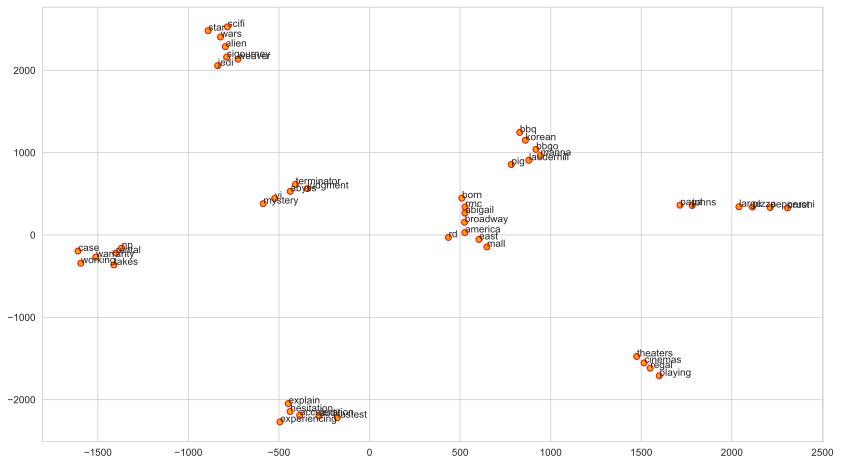

In [66]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [67]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [68]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [69]:
w2v_model.wv['jedi']

array([-0.69733727,  0.42989963, -0.20484865, -0.32060003,  0.15357013,
        0.17107402, -0.07000983, -0.60929227, -0.16619398, -0.5415183 ,
        0.5358773 , -0.32887197,  0.17138438, -0.2667347 , -0.2036692 ,
        0.26413292,  0.4312056 ,  0.9679137 , -0.16061799,  0.6451434 ,
       -0.02422083, -0.4917041 , -0.6473909 ,  0.19885814,  0.3279726 ,
        0.3939101 , -0.12369041, -0.25600097,  0.5802699 ,  0.5128258 ,
       -0.31432715,  0.59694415, -0.09771923, -0.12016183, -0.4625989 ,
       -0.51175076,  0.50256675, -0.65309405,  0.01429437,  0.22101511,
        1.2163532 , -0.39752427, -0.31794992,  0.4627876 , -0.17782706,
       -0.57367957, -0.18255645, -0.3191506 , -0.09599373,  0.47134346,
       -0.31273028, -0.23866077, -0.02158412,  0.43791673,  0.72442454,
        0.04704815, -0.19979809, -1.0000892 ,  0.14757912,  0.45251387,
       -0.34035048, -0.36194637, -0.31755856, -0.06686935, -0.18941167,
       -0.11212672,  0.24236943,  0.18613051, -0.10341638, -0.21

#### Build framework for getting document level embeddings

In [70]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [71]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.40,0.16,-0.19,0.76,0.68,0.92,-0.43,0.13,0.04,-0.89,0.32,-0.48,0.33,-0.69,-0.24,...,-0.10,0.00,-0.13,0.53,0.63,0.11,0.38,0.07,-0.33,-0.41,-0.06,0.48,0.12,0.85,0.16
1,0.37,-0.17,-0.17,0.10,0.02,0.16,0.56,-0.25,0.14,-0.11,0.68,-0.19,0.31,-0.01,0.13,...,-0.33,-0.68,-0.57,-0.18,0.65,0.96,-0.97,0.58,0.30,0.14,0.58,0.09,0.10,1.12,0.10
2,0.34,-0.20,0.13,0.08,0.05,0.72,0.55,-0.18,-0.66,0.30,0.04,-0.78,0.93,-0.31,0.08,...,0.09,-0.20,-0.20,-0.26,0.11,0.29,-0.57,-0.35,0.43,0.46,0.18,0.25,0.15,0.38,0.27
3,-0.33,-0.19,-0.02,0.29,0.07,-0.32,-0.57,-0.33,0.60,-0.68,0.42,-0.41,-0.20,-1.27,0.05,...,-0.32,0.27,-0.38,0.07,0.14,0.67,0.40,0.04,0.51,-0.34,0.39,0.79,0.21,0.60,0.05
4,0.32,0.12,-0.01,0.44,0.30,0.22,-0.45,-0.57,-0.29,-0.30,0.74,-0.47,0.43,-0.65,0.14,...,0.08,0.31,-0.26,0.49,-0.11,0.24,-0.07,0.20,-0.36,-0.71,0.48,0.50,-0.03,0.39,0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0.47,-0.02,0.48,0.00,-0.10,0.41,0.30,-0.44,0.09,0.08,-0.16,0.04,0.53,-0.30,-0.04,...,-0.19,-0.65,-0.16,-0.66,-0.16,0.52,-0.67,0.25,0.12,-0.10,0.14,0.63,0.06,0.61,0.33
746,-0.83,0.21,-0.08,-0.22,0.20,0.14,-0.72,0.01,0.44,-0.71,0.03,-0.17,-0.95,-0.83,0.21,...,-0.13,0.17,0.06,0.65,-0.28,0.99,0.39,0.54,0.17,-0.76,0.81,-0.07,-0.07,0.99,-0.30
747,0.44,-0.27,0.66,-0.03,0.05,0.42,0.44,-0.67,-0.39,0.46,-0.31,0.25,0.49,-0.43,0.34,...,0.09,-1.32,-0.16,-0.67,-0.23,0.71,-0.94,0.02,-0.05,-0.04,-0.11,0.60,0.23,0.39,0.94
748,0.00,0.22,0.32,-0.14,0.18,0.24,-0.52,-0.59,0.45,-0.60,1.30,-0.23,0.18,-0.94,0.42,...,0.37,0.19,-0.22,0.75,0.37,-0.18,-0.21,0.22,-0.18,-0.01,0.03,0.66,0.29,0.07,0.83


In [72]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with GaussianNB Classifier

In [112]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61
5,TF-IDF LinearSVC All Features,0.72,0.73
6,Word2vec LinearSVC All Features,0.65,0.66
7,Word2Vec LinearSVC Optimal Features Selected: 53,0.69,0.69
8,Word2Vec Naive Bayes Optimal Features Selected: 53,0.68,0.69
9,Word2Vec Naive Bayes All Features,0.68,0.69


In [102]:
cm_nb_w2v

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 15,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  6,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  4,  8,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  8, 19,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 13,  5,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  7,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  5, 12,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  5, 11]],
      dtype=int64)

In [103]:
print(report_nb_w2v)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.65      0.79      0.71        19
 coffee-ordering-2       0.67      0.50      0.57        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.67      0.70      0.68        20
   movie-tickets-2       0.47      0.36      0.41        22
   movie-tickets-3       0.66      0.79      0.72        24
  pizza-ordering-1       0.67      0.57      0.62        14
  pizza-ordering-2       0.76      0.83      0.79        23
restaurant-table-1       0.62      0.59      0.60        22
restaurant-table-2       0.58      0.41      0.48        17
restaurant-table-3       0.57      0.75      0.65        16
       uber-lyft-1       0.83      0.67      0.74        15
       uber-lyft-2       0.65      0.85      0.73        13

          accuracy                           0.69       250
         macro avg       0.70      0.69      0.69       25

In [108]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

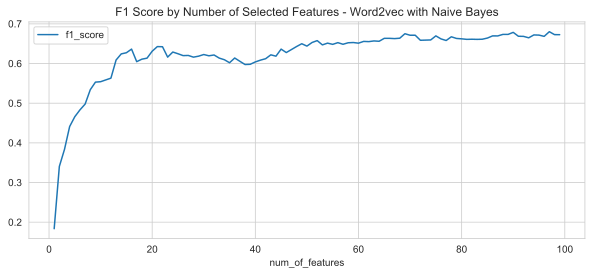

In [109]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [110]:
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
96,97,0.68,0.69
89,90,0.68,0.68
68,69,0.68,0.68
88,89,0.67,0.68
87,88,0.67,0.68


In [107]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 97, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: 97", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61
5,TF-IDF LinearSVC All Features,0.72,0.73
6,Word2vec LinearSVC All Features,0.65,0.66
7,Word2Vec LinearSVC Optimal Features Selected: 53,0.69,0.69
8,Word2Vec Naive Bayes Optimal Features Selected: 53,0.68,0.69


## Word2vec Feature Benchmarking with LinearSVC Classifier

In [73]:
from sklearn.svm import LinearSVC

model_w2v = LinearSVC()
cm_svc_w2v, pred_svc_w2v, f1_svc_w2v, report_svc_w2v, accuracy_svc_w2v = Build_Model(model_w2v, w2v_feature_array, y_train, w2v_test_array, y_test)

In [74]:
from sklearn.metrics import confusion_matrix

cm_svc_w2v

array([[17,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14,  7,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  9,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 13,  3,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5, 11,  5,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  7, 18,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  4,  5,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  9, 17,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  6,  7,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  5, 14,  0,  0],
       [ 1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 11,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  4, 10]],
      dtype=int64)

In [75]:
from sklearn import metrics
print(report_svc_w2v)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.94      0.97        18
 coffee-ordering-1       0.61      0.74      0.67        19
 coffee-ordering-2       0.60      0.56      0.58        16
      movie-finder       0.90      0.82      0.86        11
   movie-tickets-1       0.76      0.65      0.70        20
   movie-tickets-2       0.50      0.50      0.50        22
   movie-tickets-3       0.67      0.75      0.71        24
  pizza-ordering-1       0.36      0.29      0.32        14
  pizza-ordering-2       0.65      0.74      0.69        23
restaurant-table-1       0.71      0.45      0.56        22
restaurant-table-2       0.47      0.41      0.44        17
restaurant-table-3       0.61      0.88      0.72        16
       uber-lyft-1       0.73      0.73      0.73        15
       uber-lyft-2       0.67      0.77      0.71        13

          accuracy                           0.66       250
         macro avg       0.66      0.66      0.65       25

In [76]:
# Save benchmark output
rows_benchmarks.append(["Word2vec LinearSVC All Features", f1_svc_w2v, accuracy_svc_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61
5,TF-IDF LinearSVC All Features,0.72,0.73
6,Word2vec LinearSVC All Features,0.65,0.66


## Feature Selection - Word2vec with LinearSVC

In [83]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_svc_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

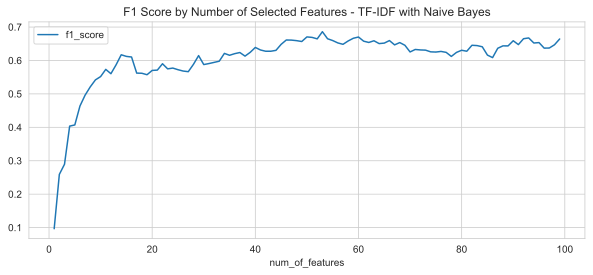

In [80]:
sel_svc_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - WOrd2vec with LinearSVC", figsize=(10, 4))

In [84]:
sel_svc_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
52,53,0.69,0.69
49,50,0.67,0.68
59,60,0.67,0.67
50,51,0.67,0.67
92,93,0.67,0.68


In [87]:
cm_w2v_svc

array([[18,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 13,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  6, 10,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0, 14,  9,  2,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5,  9,  4,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  3, 18,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  8,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  5, 16,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  9,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  4, 14,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  4, 11]],
      dtype=int64)

In [89]:
print(report_w2v_svc)

precision    recall  f1-score   support

auto-repair-appt-1       0.95      1.00      0.97        18
 coffee-ordering-1       0.68      0.68      0.68        19
 coffee-ordering-2       0.56      0.62      0.59        16
      movie-finder       0.91      0.91      0.91        11
   movie-tickets-1       0.54      0.70      0.61        20
   movie-tickets-2       0.50      0.41      0.45        22
   movie-tickets-3       0.78      0.75      0.77        24
  pizza-ordering-1       0.57      0.57      0.57        14
  pizza-ordering-2       0.76      0.70      0.73        23
restaurant-table-1       0.75      0.55      0.63        22
restaurant-table-2       0.53      0.53      0.53        17
restaurant-table-3       0.67      0.88      0.76        16
       uber-lyft-1       0.91      0.67      0.77        15
       uber-lyft-2       0.69      0.85      0.76        13

          accuracy                           0.69       250
         macro avg       0.70      0.70      0.69       25

In [86]:
cm_w2v_svc, pred_w2v_svc, f1_w2v_svc, report_w2v_svc, accuracy_w2v_svc = SelectBestModelFeatures_Chi(model_w2v, 53, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec LinearSVC Optimal Features Selected: 53", f1_w2v_svc, accuracy_w2v_svc])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW LinearSVC All Features,0.67,0.68
1,BOW Naive Bayes All Features,0.71,0.72
2,BOW Naive Bayes Optimal Features Selected: 960,0.76,0.76
3,TF-IDF Naive Bayes All Features,0.52,0.59
4,TF-IDF Naive Bayes Optimal Features Selected: 1115,0.57,0.61
5,TF-IDF LinearSVC All Features,0.72,0.73
6,Word2vec LinearSVC All Features,0.65,0.66
7,Word2Vec LinearSVC Optimal Features Selected: 53,0.69,0.69


## Additional Advanced Methods To Explore Further

#### GloVe Embeddings with spaCy

In [50]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [51]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
continental,0.24,0.05,0.88,-0.08,0.66,-0.10,-0.02,0.64,-0.50,1.30,-0.57,-0.15,-0.41,0.60,0.66,...,0.55,-0.01,0.16,0.03,0.27,-0.10,0.62,-0.12,-0.47,0.40,0.03,0.71,0.03,-0.62,-0.05
rows,0.69,0.09,-0.64,-0.02,0.52,0.12,-0.11,0.40,-0.30,0.30,0.29,0.23,0.12,-0.04,0.11,...,-0.10,-0.01,0.09,0.26,-0.29,0.24,0.23,-0.02,-0.27,-0.68,0.10,-0.30,0.04,0.48,0.08
wines,-0.87,0.02,0.36,-1.26,1.01,0.39,0.53,0.43,-0.38,1.68,-0.11,0.82,-0.51,-0.54,0.32,...,0.73,0.52,0.34,-0.04,0.80,0.32,0.92,-0.71,0.18,-0.42,-0.88,0.55,-0.68,1.03,-0.19
artists,0.05,-0.34,0.20,-0.16,-0.02,-0.05,0.03,0.22,-0.28,2.49,0.31,-0.05,-0.20,-0.20,0.53,...,0.26,0.52,0.14,-0.09,0.03,-0.74,-0.19,0.08,0.51,-0.16,-0.21,0.18,-0.04,0.13,0.49
rebel,0.08,-0.30,0.33,-0.03,0.32,-0.48,-0.80,0.60,-0.06,1.54,-0.11,-0.34,-0.65,-0.45,-0.06,...,-0.08,0.21,0.52,0.09,0.05,-0.59,0.21,-0.01,-0.39,-0.21,0.26,0.13,0.42,-0.11,-0.17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pads,0.50,0.44,-0.43,-0.02,-0.11,0.16,0.04,-0.17,0.03,0.07,0.61,0.25,0.15,0.29,-0.26,...,-0.61,-0.51,-0.32,-0.44,-0.55,-0.09,0.04,0.45,-0.25,-0.22,-0.07,0.41,0.12,0.71,-0.29
title,-0.27,-0.11,-0.44,0.06,0.07,-0.09,-0.02,-0.22,0.02,1.84,-0.50,0.73,0.39,-0.01,0.49,...,-0.06,-0.26,0.32,0.26,-0.56,0.21,-0.47,-0.39,-0.18,0.51,0.08,-0.25,-0.66,0.30,-0.37
closest,0.52,-0.47,-0.28,0.34,0.92,-0.35,-0.12,0.58,0.24,2.27,-0.05,0.34,0.04,-0.11,0.18,...,-0.05,-0.43,-0.35,-0.19,0.16,0.11,0.07,-0.10,0.42,0.28,0.10,0.01,-0.32,-0.10,0.55
dixon,-0.22,1.19,-0.16,-0.57,0.35,-0.57,0.02,-0.21,-0.03,-0.36,0.31,-0.31,0.39,-0.45,-0.37,...,-0.02,0.08,-0.08,-0.02,-0.37,0.29,0.27,0.24,-0.26,0.25,-0.20,0.37,0.05,-0.44,-0.02


In [52]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(5091, 300)


#### Word2vec features with Fastext Model

In [53]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [54]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['dinner', 'capital', 'food', 'thinking', 'eat'],
 'pizza': ['pepperoni', 'cheese', 'crust', 'sausage', 'large'],
 'terminator': ['nevermind',
  'terrific',
  'event',
  'unfortunately',
  'confirming'],
 'star': ['wars', 'born', 'oct', 'fresno', 'rating'],
 'audi': ['weird', 'wrong', 'model', 'jones', 'appointment'],
 'east': ['requested', 'atlanta', 'chicago', 'suppose', 'places'],
 'korean': ['bbq', 'pig', 'accommodate', 'requests', 'alex'],
 'playing': ['movie', 'showing', 'tickets', 'show', 'theater']}

#### PCA on Fasttext Model

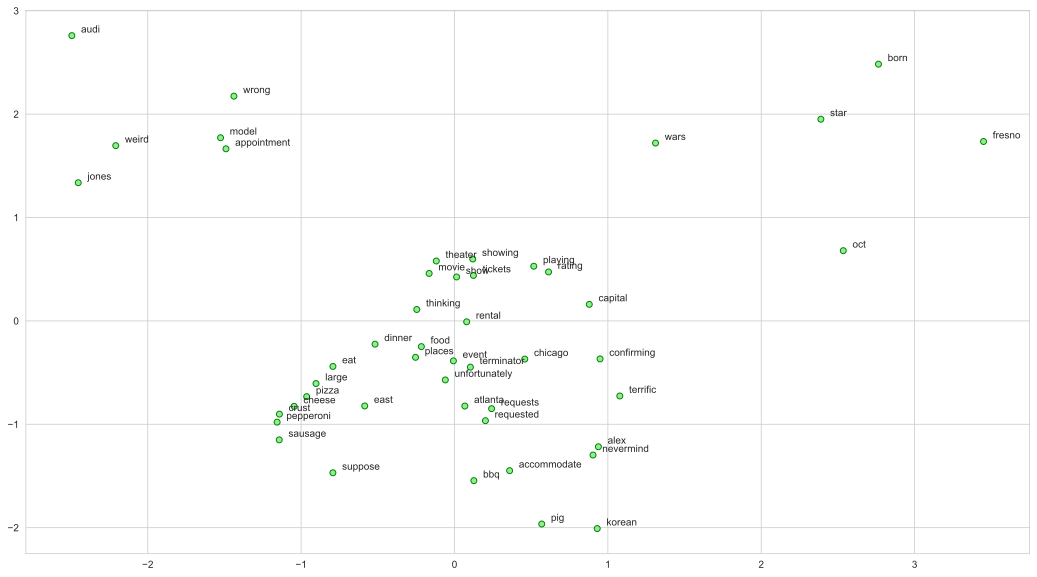

In [55]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [56]:
ft_model.wv['rental']

array([-0.2456603 , -0.3847549 ,  0.06492562,  0.04740023, -0.05075805,
       -0.22694312,  0.4215116 , -0.33982405, -0.04370858,  0.0629853 ,
       -0.3409566 ,  0.00812502, -0.0774149 ,  0.48186895,  0.21284053,
        0.3371108 , -0.25463784, -0.17870781,  0.18154614, -0.40187714,
       -0.11597514,  0.06976771, -0.2827826 ,  0.34207228,  0.11847469,
        0.09189652,  0.4980718 , -0.389526  , -0.03210843, -0.16801834,
       -0.6243001 ,  0.18326154,  0.2597041 , -0.03512648, -0.03855328,
       -0.23020533, -0.21311814,  0.24731663, -0.12095507,  0.21898097,
       -0.03530402,  0.11089047,  0.38267976, -0.03408687,  0.47464603,
        0.13449542,  0.16546832, -0.0557306 , -0.17744146, -0.08903551,
       -0.1279476 , -0.05045699,  0.1012897 , -0.2515585 , -0.06074018,
        0.3012346 ,  0.2712584 ,  0.00910348, -0.2822897 ,  0.10751042,
        0.1602443 ,  0.05004477, -0.39422616, -0.19322552,  0.03605143,
       -0.2429987 , -0.26940596, -0.05992399, -0.18235217, -0.04

In [57]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.103287175
0.7937065


In [58]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies
